<a href="https://colab.research.google.com/github/ganeshsembedded-maker/patient-readmission-ml-end-to-end/blob/main/Patient_Readmission_ML_End_to_End.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
# ===============================
# 1. IMPORT LIBRARIES
# ===============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [66]:
# ===============================
# 2. LOAD DATASETS
# ===============================

train_df = pd.read_csv('/content/Train-1617360447408-1660719685476.csv')
test_df  = pd.read_csv('/content/test-1617360461595-1660719701431.csv')

display(train_df.head())


,index,encounter_id,patient_id,race,gender,age,weight,time_in_hospital,medical_specialty,num_lab_procedures,...,X19,X20,X21,X22,X23,X24,X25,change,diabetesMed,readmitted
0,69375,197029140,51521940,Hispanic,Male,[80-90),?,4,Emergency/Trauma,39,...,No,No,No,No,No,No,No,No,Yes,1
1,57272,163571946,92631357,Caucasian,Male,[60-70),?,3,Emergency/Trauma,34,...,No,No,No,No,No,No,No,No,No,0
2,82347,256497366,30023982,Caucasian,Female,[50-60),?,6,Nephrology,50,...,No,Down,No,No,No,No,No,Ch,Yes,1
3,89608,289891212,93606021,AfricanAmerican,Female,[70-80),?,5,?,63,...,No,Down,No,No,No,No,No,Ch,Yes,1
4,24091,81873900,23464296,Caucasian,Male,[70-80),?,9,Psychiatry,17,...,No,No,No,No,No,No,No,No,No,1


In [67]:
display(test_df.head())

,index,encounter_id,patient_id,race,gender,age,weight,time_in_hospital,medical_specialty,num_lab_procedures,...,X18,X19,X20,X21,X22,X23,X24,X25,change,diabetesMed
0,11128,46325466,3928383,Caucasian,Female,[70-80),?,3,?,45,...,No,No,No,No,No,No,No,No,No,Yes
1,79758,245219616,60926103,Caucasian,Male,[60-70),?,2,?,10,...,No,No,No,No,No,No,No,No,No,Yes
2,52497,155321232,25234848,AfricanAmerican,Male,[70-80),?,11,InternalMedicine,41,...,No,No,Steady,No,No,No,No,No,No,Yes
3,64504,179491944,86935374,Caucasian,Female,[70-80),?,1,InternalMedicine,71,...,No,No,No,No,No,No,No,No,No,No
4,987,7425954,2486826,AfricanAmerican,Female,[50-60),?,7,InternalMedicine,59,...,No,No,Steady,No,No,No,No,No,Ch,Yes


In [68]:
# ===============================
# 3. DATA EXPLORATION
# ===============================

print(train_df.shape)
print(train_df.info())
print(train_df.isnull().sum())


(66587, 49)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66587 entries, 0 to 66586
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               66587 non-null  int64  
 1   encounter_id        66587 non-null  int64  
 2   patient_id          66587 non-null  int64  
 3   race                66587 non-null  object 
 4   gender              66587 non-null  object 
 5   age                 66587 non-null  object 
 6   weight              66587 non-null  object 
 7   time_in_hospital    66587 non-null  int64  
 8   medical_specialty   66587 non-null  object 
 9   num_lab_procedures  66587 non-null  int64  
 10  num_procedures      66587 non-null  int64  
 11  num_medications     66587 non-null  int64  
 12  number_outpatient   66587 non-null  int64  
 13  number_emergency    66587 non-null  int64  
 14  number_inpatient    66587 non-null  int64  
 15  diag_1              66587 non-null  objec

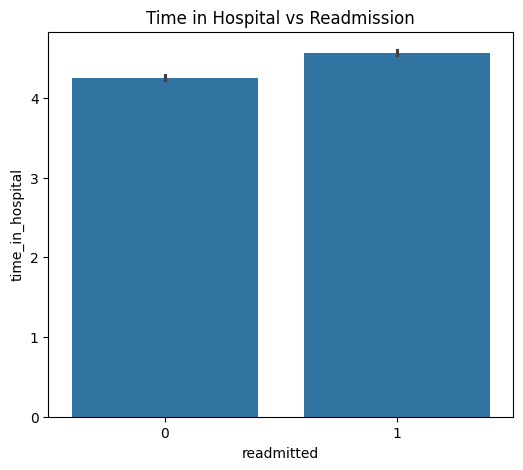

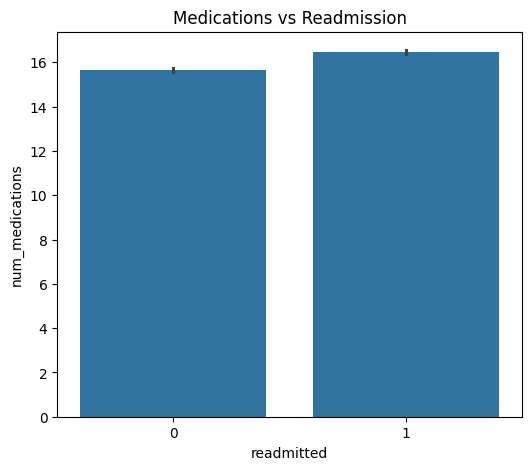

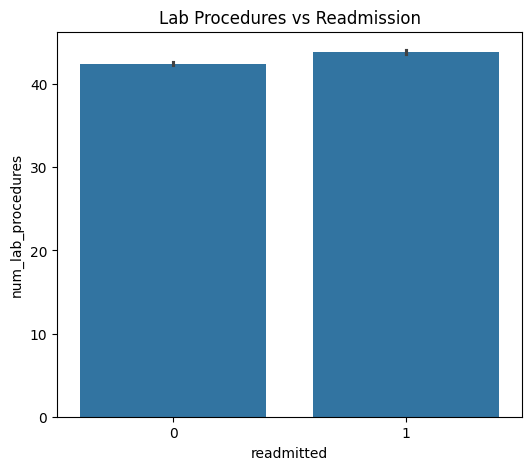

In [69]:
# ===============================
# 4. EXPLORATORY DATA ANALYSIS (EDA)
# ===============================

plt.figure(figsize=(6,5))
sns.barplot(x='readmitted', y='time_in_hospital', data=train_df)
plt.title('Time in Hospital vs Readmission')
plt.show()

plt.figure(figsize=(6,5))
sns.barplot(x='readmitted', y='num_medications', data=train_df)
plt.title('Medications vs Readmission')
plt.show()

plt.figure(figsize=(6,5))
sns.barplot(x='readmitted', y='num_lab_procedures', data=train_df)
plt.title('Lab Procedures vs Readmission')
plt.show()


In [70]:
# ===============================
# 5. DATA CLEANING
# ===============================

# Drop highly missing / unnecessary columns
train_df.drop(['X1', 'X2', 'weight'], axis=1, inplace=True, errors='ignore')
test_df.drop(['X1', 'X2', 'weight'], axis=1, inplace=True, errors='ignore')


In [71]:
# ===============================
# 6. CATEGORICAL FEATURE ENCODING
# ===============================

cat_cols = train_df.select_dtypes(include='object').columns

for col in cat_cols:
    le = LabelEncoder()

    combined = pd.concat([
        train_df[col].astype(str),
        test_df[col].astype(str)
    ])

    le.fit(combined)

    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col]  = le.transform(test_df[col].astype(str))


In [72]:
# ===============================
# 7. FEATURE & TARGET SPLIT
# ===============================

X = train_df.drop('readmitted', axis=1)
y = train_df['readmitted']


In [73]:
# ===============================
# 8. TRAIN-VALIDATION SPLIT
# ===============================

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [74]:
# ===============================
# 9. LOGISTIC REGRESSION MODEL
# ===============================

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

lr_preds = lr.predict(X_val)
lr_f1 = f1_score(y_val, lr_preds)

print("Logistic Regression F1 Score:", lr_f1)


Logistic Regression F1 Score: 0.4274794003772461


In [75]:
# ===============================
# 10. RANDOM FOREST MODEL
# ===============================

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)

rf_preds = rf.predict(X_val)
rf_f1 = f1_score(y_val, rf_preds)

print("Random Forest F1 Score:", rf_f1)

Random Forest F1 Score: 0.7654530059271804


In [76]:
# ===============================
# 11. XGBOOST MODEL
# ===============================

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=2,
    eval_metric='logloss'
)

xgb.fit(X_train, y_train)

xgb_preds = xgb.predict(X_val)
xgb_f1 = f1_score(y_val, xgb_preds)

print("XGBoost F1 Score:", xgb_f1)


XGBoost F1 Score: 0.7153673010026601


In [77]:
# ===============================
# 12. MODEL COMPARISON
# ===============================

print(f"Logistic Regression F1 Score : {lr_f1*100:.2f}%")
print(f"Random Forest F1 Score       : {rf_f1*100:.2f}%")
print(f"XGBoost F1 Score             : {xgb_f1*100:.2f}%")

Logistic Regression F1 Score : 42.75%
Random Forest F1 Score       : 76.55%
XGBoost F1 Score             : 71.54%


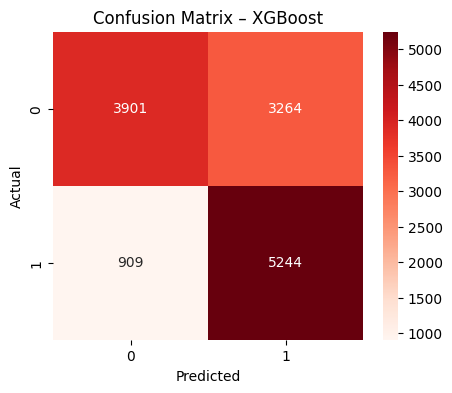

In [78]:
# ===============================
# 13. CONFUSION MATRIX (BEST MODEL)
# ===============================

cm = confusion_matrix(y_val, xgb_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix – XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
